You should add this link to your google drive. Click the folder. https://drive.google.com/drive/folders/1mqb-JgPqvslCQKX9i51X6Ofdme1c0Jc9?usp=drive_link .In the top right, click Add a shortcut to My Drive.

After finishing the hands on, download your notebook and submit it to the following form: https://docs.google.com/forms/d/1I9A53QGubXMNRXA8OsKOb_ZXIdLv2prMYIylhsSoX7s/edit

In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import os


class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.xfeatures2d.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]


class BOVHelpers:
    def __init__(self, n_clusters=20):
        self.n_clusters = n_clusters
        self.kmeans_obj = KMeans(n_clusters=n_clusters)
        self.kmeans_ret = None
        self.descriptor_vstack = None
        self.mega_histogram = None
        self.clf = SVC()

    def cluster(self):
        """
		cluster using KMeans algorithm,

		"""
        self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)

    def developVocabulary(self, n_images, descriptor_list):

        """
		Each cluster denotes a particular visual word
		Every image can be represeted as a combination of multiple
		visual words. The best method is to generate a sparse histogram
		that contains the frequency of occurence of each visual word

		Thus the vocabulary comprises of a set of histograms of encompassing
		all descriptions for all images

		"""

        self.mega_histogram = np.array([np.zeros(self.n_clusters) for i in range(n_images)])
        old_count = 0
        for i in range(n_images):
            l = len(descriptor_list[i])
            for j in range(l):
                idx = self.kmeans_ret[old_count + j]
                self.mega_histogram[i][idx] += 1
            old_count += l
        print("Vocabulary Histogram Generated")

    def standardize(self, std=None):
        """

		standardize is required to normalize the distribution
		wrt sample size and features. If not normalized, the classifier may become
		biased due to steep variances.

		"""
        if std is None:
            self.scale = StandardScaler().fit(self.mega_histogram)
            self.mega_histogram = self.scale.transform(self.mega_histogram)
        else:
            print("STD not none. External STD supplied")
            self.mega_histogram = std.transform(self.mega_histogram)

    def formatND(self, l):
        """
		restructures list into vstack array of shape
		M samples x N features for sklearn

		"""
        vStack = np.array(l[0])
        for remaining in l[1:]:
            vStack = np.vstack((vStack, remaining))
        self.descriptor_vstack = vStack.copy()
        return

    def train(self, train_labels):
        """
		uses sklearn.svm.SVC classifier (SVM)


		"""
        print("Training SVM")
        print(self.clf)
        print("Train labels", train_labels)
        self.clf.fit(self.mega_histogram, train_labels)
        print("Training completed")

    def predict(self, iplist):
        predictions = self.clf.predict(iplist)
        return predictions

    def plotHist(self, vocabulary=None):
        print("Plotting histogram")
        if vocabulary is None:
            vocabulary = self.mega_histogram

        x_scalar = np.arange(self.n_clusters)
        y_scalar = np.array([abs(np.sum(vocabulary[:, h], dtype=np.int32)) for h in range(self.n_clusters)])

        print(y_scalar)

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()


class FileHelpers:

    def __init__(self):
        pass

    def getFiles(self, path):
        """
		- returns  a dictionary of all files
		having key => value as  objectname => image path

		- returns total number of files.

		"""
        imlist = {}
        count = 0
        for each in os.listdir(path):
            print(" #### Reading image category ", each, " ##### ")
            imlist[each] = []
            for imagefile in os.listdir(path + '/' + each):
                print("Reading file ", imagefile)
                im = cv2.imread(path + '/' + each + '/' + imagefile, 0)
                imlist[each].append(im)
                count += 1

        return [imlist, count]

In [5]:
import cv2
import numpy as np
from glob import glob
import argparse
from matplotlib import pyplot as plt


class BOV:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bov_helper = BOVHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.descriptor_list = []




    def trainModel(self):
        """
        This method contains the entire module
        required for training the bag of visual words model

        Use of helper functions will be extensive.

        """

        # read file. prepare file lists.
        self.images, self.trainImageCount = self.file_helper.getFiles(self.train_path)
        # extract SIFT Features from each image
        label_count = 0
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            print ("Computing Features for ", word)
            for im in imlist:
                # cv2.imshow("im", im)
                # cv2.waitKey()
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)

            label_count += 1


        # perform clustering
        self.bov_helper.formatND(self.descriptor_list)
        self.bov_helper.cluster()
        self.bov_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

        # show vocabulary trained
        self.bov_helper.plotHist()

        self.bov_helper.standardize()
        self.bov_helper.train(self.train_labels)


    def recognize(self,test_img, test_image_path=None):

        """
        This method recognizes a single image
        It can be utilized individually as well.


        """

        kp, des = self.im_helper.features(test_img)
        # print kp
        print (des.shape)

        # generate vocab for test image

        # locate nearest clusters for each of
        # the visual word (feature) present in the image

        # test_ret =<> return of kmeans nearest clusters for N features
        test_ret = self.bov_helper.kmeans_obj.predict(des)
        vocab = np.zeros((1,self.no_clusters))
        vocab = np.array(vocab, 'float32')
        # print test_ret

        # print vocab

        for value in test_ret:
            vocab[0,value]+=1


        #print (vocab)

        # Scale the features
        vocab = self.bov_helper.scale.transform(vocab)
        # predict the class of the image
        lb = self.bov_helper.predict(vocab)
        # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
        return lb



    def testModel(self):
        """
        This method is to test the trained classifier

        read all images from testing path
        use BOVHelpers.predict() function to obtain classes of each image

        """
        correctClassifications = 0
        self.testImages, self.testImageCount = self.file_helper.getFiles(self.test_path)

        predictions = []

        for word, imlist in self.testImages.items():
            print ("processing " ,word)
            for im in imlist:
                # print imlist[0].shape, imlist[1].shape
                print (im.shape)
                #returns label of svm
                cl = self.recognize(im)
                print (cl)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))]
                    })

                if(self.name_dict[str(int(cl[0]))]==word):
                    correctClassifications = correctClassifications + 1

        print("Test Accuracy = " + str((correctClassifications/self.testImageCount) * 100))
        #print (predictions)
        for each in predictions:
            # cv2.imshow(each['object_name'], each['image'])
            # cv2.waitKey()
            # cv2.destroyWindow(each['object_name'])
            #
            plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            plt.title(each['object_name'])
            plt.show()


    def print_vars(self):
        pass

 #### Reading image category  motorbike  ##### 
Reading file  image_0012.jpg
Reading file  image_0003.jpg
Reading file  image_0016.jpg
Reading file  image_0009.jpg
Reading file  image_0001.jpg
Reading file  image_0010.jpg
Reading file  image_0014.jpg
Reading file  image_0004.jpg
Reading file  image_0002.jpg
Reading file  image_0011.jpg
Reading file  image_0007.jpg
Reading file  image_0008.jpg
Reading file  image_0015.jpg
Reading file  image_0013.jpg
 #### Reading image category  dollar_bill  ##### 
Reading file  image_0001.jpg
Reading file  image_0014.jpg
Reading file  image_0002.jpg
Reading file  image_0008.jpg
Reading file  image_0007.jpg
Reading file  image_0011.jpg
Reading file  image_0013.jpg
Reading file  image_0015.jpg
Reading file  image_0018.jpg
Reading file  image_0012.jpg
Reading file  image_0016.jpg
Reading file  image_0003.jpg
Reading file  image_0010.jpg
Reading file  image_0009.jpg
 #### Reading image category  Soccer_Ball  ##### 
Reading file  image_0046.jpg
Reading fil

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Vocabulary Histogram Generated
Plotting histogram
[234 387 195 265 279 260 197 497 259 529 459 423 151 218 341 262 353 254
 246 213 272 231 297 228 213 196 294 243 384 239 207 178 338 247 185 225
 338 238 207 181 146 226 189 344 212 233 205 293 432 177 247 155 235 172
 192 176 270 210 164 209 199 152 190 243 173 237 268 359 185 183 256 259
 170 232 194 239 373 224 290 339 187 274 225 158 199 207 538 283 337 252
 289 281 185 263 264 192 190 256 197 180]


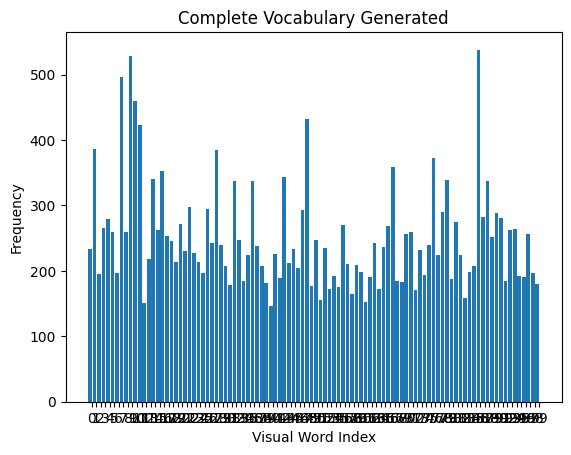

Training SVM
SVC()
Train labels [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Training completed
 #### Reading image category  dollar_bill  ##### 
Reading file  image_0040.jpg
Reading file  image_0048.jpg
 #### Reading image category  Soccer_Ball  ##### 
Reading file  image_0013.jpg
Reading file  image_0032.jpg
Reading file  image_0046.jpg
 #### Reading image category  accordian  ##### 
Reading file  image_0026.jpg
Reading file  image_0023.jpg
 #### Reading image category  motorbike  ##### 
Reading file  image_0030.jpg
Reading file  image_0044.jpg
processing  dollar_bill
(135, 300)
(514, 128)
[1.]
(133, 300)
(418, 128)
[1.]
processing  Soccer_Ball
(290, 300)
(250, 128)
[2.]
(300, 279)
(227, 128)
[2.]
(225, 300)
(90, 128)
[2.]
processing  accordian
(243, 300)
(833, 128)
[3.]
(262, 300)
(489, 128)
[3.]
processing  motorbike
(160, 270)
(336, 128)
[0.]
(172, 269)

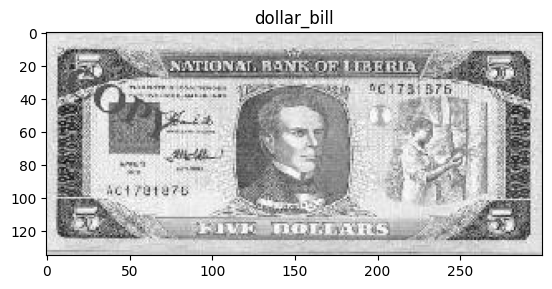

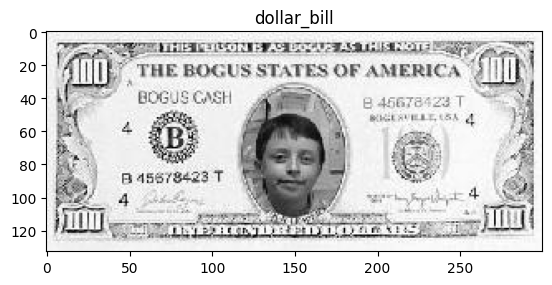

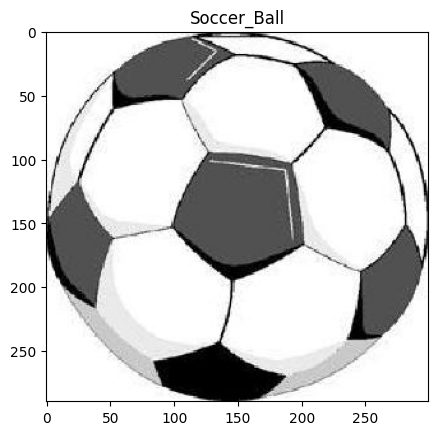

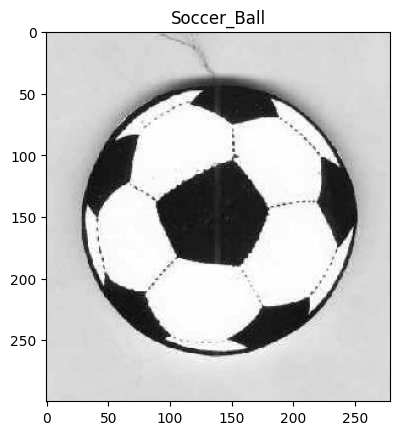

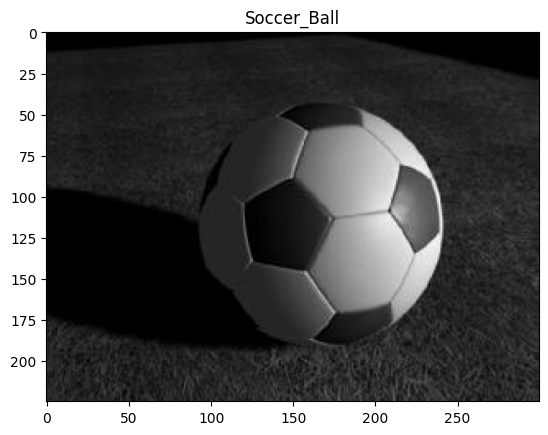

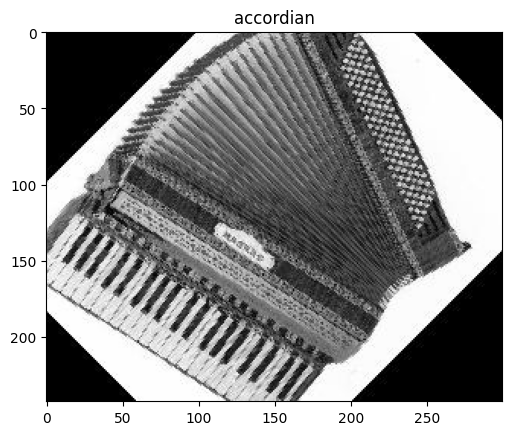

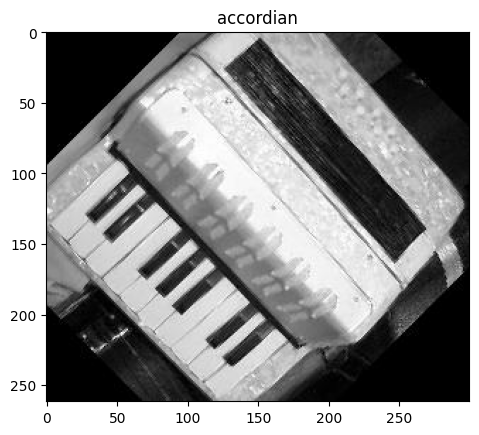

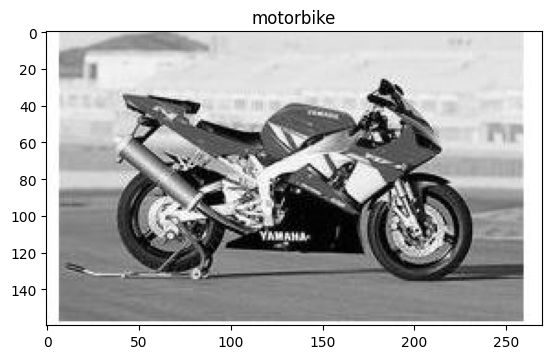

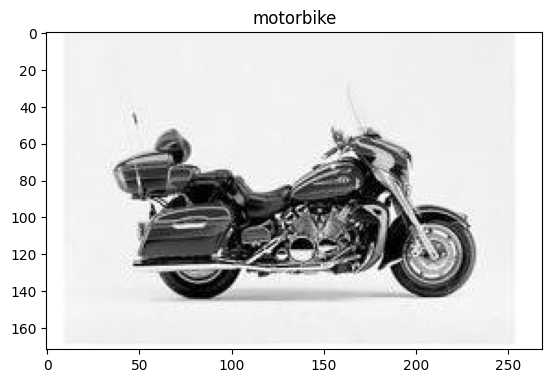

In [6]:
bov = BOV(no_clusters=100)

# set training paths
bov.train_path = '/content/drive/MyDrive/images/train'
# set testing paths
bov.test_path = '/content/drive/MyDrive/images/test'
# train the model
bov.trainModel()
# test model
bov.testModel()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
